# Detecting intrusion using login data

### Using logistic regression, I aim to predict whether login attempts are malicious. Based on the accuracy of the result, I will also explore whether thresholds should be set to balance security with user experience (such as requiring MFA vs blocking the login attempt altogether)

In [57]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Data Exploration

### I found this dataset on Kaggle: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset?select=cybersecurity_intrusion_data.csv

The dataset contains almost 10,000 login attempts to a fictional website, including a target variable of "attack detected". I'm assuming this "attack detected" has been manually labeled by some incident response team

In [58]:
raw_data = pd.read_csv('cybersecurity_intrusion_data.csv')
df = raw_data.copy()
df.shape

(9537, 11)

In [59]:
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      9537 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [61]:
categorical = ['protocol_type', 'encryption_used', 'browser_type']
numeric = ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access', 'attack_detected']

There are no null fields, so there is no need to impute values. One observation is that location is not considered which would be a very strong indicator

Let's see how many of the login attempts were detected attacks

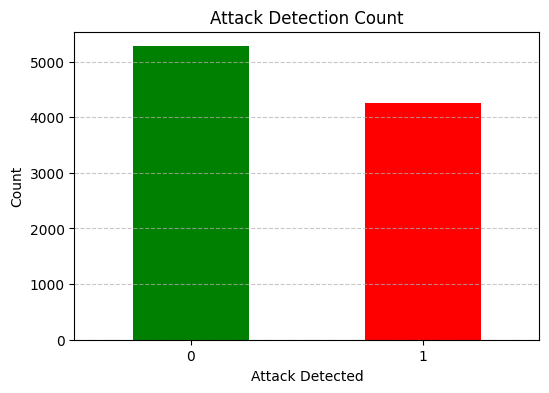

In [62]:
attack_counts = df.attack_detected.value_counts()

plt.figure(figsize=(6,4))
attack_counts.plot(kind='bar', color=['green', 'red'])
plt.xlabel("Attack Detected")
plt.ylabel("Count")
plt.title("Attack Detection Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()

It looks like there are quite a few attacks detected by the manually labeled data. Let's determine if any of the features are correlated with each other

Now let's determine if any of the features are correlated with each other

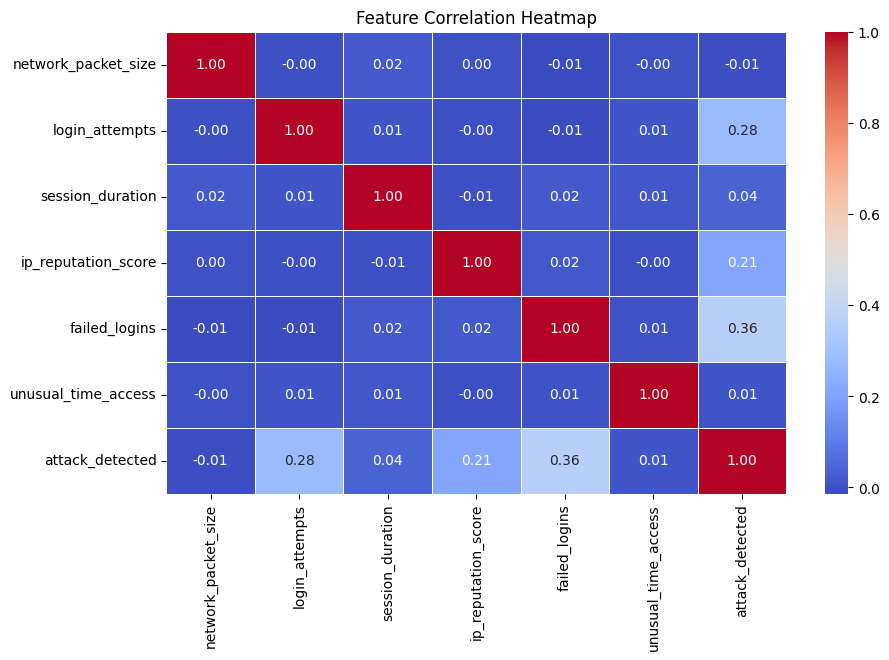

In [63]:
df_numeric = df[numeric] 

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

# Set figure size
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Heatmap")

# Show plot
plt.show()

Looks like there is relatively little correlation between variables. Let's get on to preparing the data!

## Preparing the data

I'm going to make the decision to omit session_duration. This might be useful if we were to enforce a lockout period, but it won't be helpful in determining whether the any future authentication attempts are malicious

In [64]:
X = df.drop(['attack_detected', 'session_id', 'session_duration'], axis=1)
numeric.remove('attack_detected')
numeric.remove('session_duration')
y = df['attack_detected']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [66]:
X_train.head()

,network_packet_size,protocol_type,login_attempts,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access
9194,298,UDP,4,DES,0.178229,3,Chrome,0
8561,641,TCP,6,AES,0.474200,1,Firefox,0
7778,454,ICMP,2,DES,0.559826,2,Unknown,1
6785,415,TCP,2,DES,0.569155,0,Firefox,0
4920,832,TCP,2,AES,0.015135,0,Edge,1


In [67]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical),
        ('num', StandardScaler(), numeric)
    ],
    remainder='passthrough'
)

In [68]:
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=0))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['protocol_type',
                                                   'encryption_used',
                                                   'browser_type']),
                                                 ('num', StandardScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'ip_reputation_score',
                                                   'failed_logins',
                                                   'unusual_time_access'])])),
                ('classifier',
                 LogisticRegression(random_state=0, solver='liblinear'))])

Time to see how we did!

In [69]:
y_pred_train = model.predict(X_train)
print('Train model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Train model accuracy score: 0.7414


In [70]:
y_pred_test = model.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.7432


No signs of overfitting, so that's great. Let's dive deeper into the model's performance

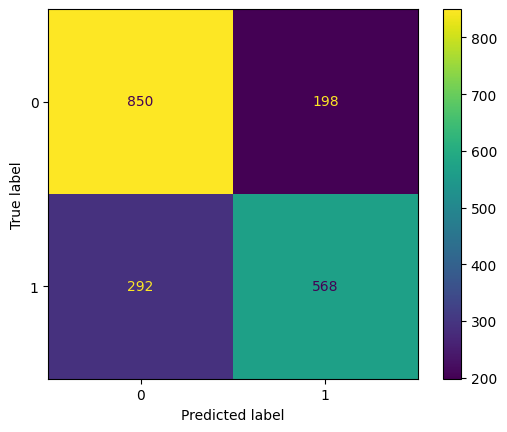

In [71]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [72]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78      1048
           1       0.74      0.66      0.70       860

    accuracy                           0.74      1908
   macro avg       0.74      0.74      0.74      1908
weighted avg       0.74      0.74      0.74      1908



It looks like the model is quite good at identifying legitimate auth attempts, but there are a few malicious attempts that are slipping through the cracks

## Let's see which variables are significant

In [73]:
X_train_sm = sm.add_constant(X_train)

X_train_sm = pd.get_dummies(X_train_sm, drop_first=True)

model_sm = sm.Logit(y_train, X_train_sm)
result = model_sm.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.527844
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        attack_detected   No. Observations:                 7629
Model:                          Logit   Df Residuals:                     7615
Method:                           MLE   Df Model:                           13
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                  0.2321
Time:                        08:45:26   Log-Likelihood:                -4026.9
converged:                       True   LL-Null:                       -5243.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.7315      0.183    -25.916      0.000      -5.089      -4.374

I'm going to try dropping `network_packet_size`, `protocol_type`, and `unusual_access_time`

## Model_v2
Only changes are dropping the insignificant variables

In [74]:
X_v2 = df.drop(['attack_detected', 'session_id', 'session_duration', 'network_packet_size', 'protocol_type', 'unusual_time_access'], axis=1)
numeric.remove('network_packet_size')
numeric.remove('unusual_time_access')
categorical.remove('protocol_type')

In [75]:
X_train_v2, X_test_v2, y_train, y_test = train_test_split(X_v2, y, test_size=0.2, random_state=0)

In [76]:
model_v2 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=0))
])

model_v2.fit(X_train_v2, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['encryption_used',
                                                   'browser_type']),
                                                 ('num', StandardScaler(),
                                                  ['login_attempts',
                                                   'ip_reputation_score',
                                                   'failed_logins'])])),
                ('classifier',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [77]:
y_pred_train_v2 = model_v2.predict(X_train_v2)
print('Train model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_v2)))

Train model accuracy score: 0.7403


In [78]:
y_pred_test_v2 = model_v2.predict(X_test_v2)
print('Test model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test_v2)))

Test model accuracy score: 0.7416


Removing these variables didn't cause the accuracy score to change which is a great sign!

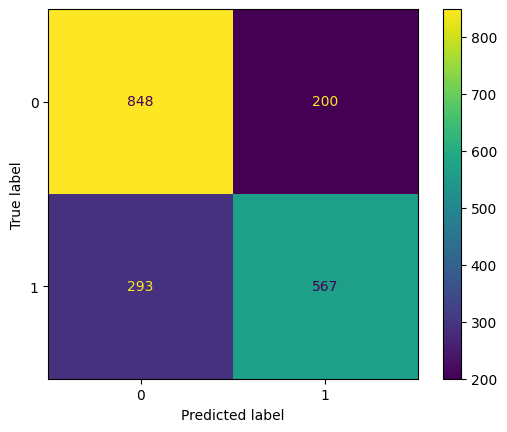

In [88]:
ConfusionMatrixDisplay.from_estimator(model_v2, X_test_v2, y_test)

In [89]:
print(classification_report(y_pred_test_v2, y_test))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1141
           1       0.66      0.74      0.70       767

    accuracy                           0.74      1908
   macro avg       0.73      0.74      0.74      1908
weighted avg       0.75      0.74      0.74      1908



## When should we require MFA or send a notification to the user that we've detected suspicious activity?

In [79]:
y_pred_probability = model_v2.predict_proba(X)[:, 1]

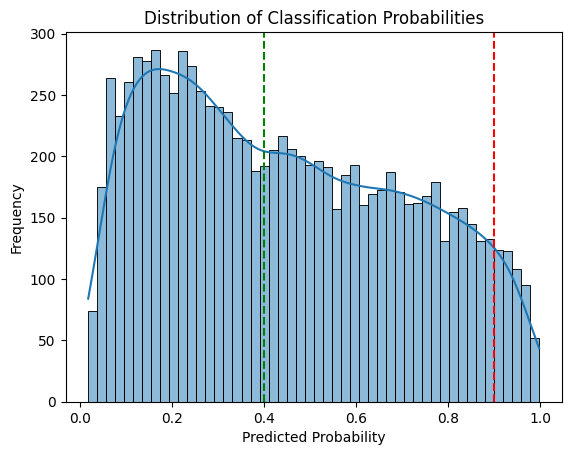

In [80]:
sns.histplot(y_pred_probability, bins=50, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Classification Probabilities')
plt.axvline(x=0.4, color='green', linestyle='--')
plt.axvline(x=0.9, color='red', linestyle='--')
plt.show()

There's no perfect place to include a threshold, but we could do something like above, where everything below the green line is authenticated with the single factor, everything between green and red requires MFA, and everything above red also includes an alert sent to the user, indicating that a suspicious login attempt was detected

In [81]:
count_no_MFA = len([x for x in y_pred_probability if x < .4])
no_MFA = count_no_MFA / len(y_pred_probability)
no_MFA

0.4847436300723498

In [82]:
count_MFA = len([x for x in y_pred_probability if x < .9])
MFA = (count_MFA - count_no_MFA) / len(y_pred_probability)
MFA

0.4628289818601237

In [83]:
count_notification = len([x for x in y_pred_probability if x > .9])
notification = count_notification / len(y_pred_probability)
notification

0.052427388067526476

If we set the above thresholds, 48% of authentications would have no MFA, 46% would require MFA, and 5% would result in an additional notification sent to the user

Here's some other great examples on Kaggle to check out!
- https://www.kaggle.com/code/nukimayasari/cybersecurity-intrusion
- https://www.kaggle.com/code/madhuraatmarambhagat/cybersecurity-intrusion-prediction